In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import time
import random

from gymnasium import spaces
import molcontrol

## Parameters
steps = 100000
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = np.array([0])

##Seed
forget_param = 1/1000.0

def lookup_table(steps, target, molecule_lifetime, dt, history_length, observable_indices, upper_mol, forget_param, RUN_SEED):
    average_death = target * dt/molecule_lifetime
    action_array, counter_array = molcontrol.table_init(len(observable_indices), upper_mol, average_death)
    rewards_overtime = molcontrol.tabular_molecule_controller(action_array, counter_array, forget_param, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED)
    return rewards_overtime, action_array, counter_array

##We run both of these functions for a large number of seeds and display the averaged results
RUN_SEEDS = np.arange(0, 10)

target_avgs = np.array([1, 2, 5, 10, 20, 30, 50])
for target in target_avgs:
    table_rewards = []
    action_arrays = []
    opt_reward = []
    upper_mol = target*3 + 10
    for SEED in RUN_SEEDS:
        rewards_overtime, action_array, counter_array = lookup_table(steps, target, molecule_lifetime, dt, history_length, observable_indices, upper_mol, forget_param, SEED)
        table_rewards.append(rewards_overtime)
        action_arrays.append(action_array)
    
        rewards_overtime_opt = molcontrol.optimal_solution(steps, target, molecule_lifetime, dt, SEED)
        opt_reward.append(rewards_overtime_opt)
    
    reward_array = np.stack(table_rewards)
    reward_opt_array = np.stack(opt_reward)
    action_arrs = np.stack(action_arrays)
    
    np.savetxt("reward_array"+str(target)+".txt", reward_array)
    np.savetxt("reward_opt_array"+str(target)+".txt", reward_opt_array)
    np.savetxt("action_arrs"+str(target)+".txt", action_arrs)
    
    print ("Done for all the seeds for average ", target)
print ("Done!")



Done for all the seeds for average  1
Done for all the seeds for average  2
Done for all the seeds for average  5
Done for all the seeds for average  10
Done for all the seeds for average  20
Done for all the seeds for average  30
Done for all the seeds for average  50
Done!


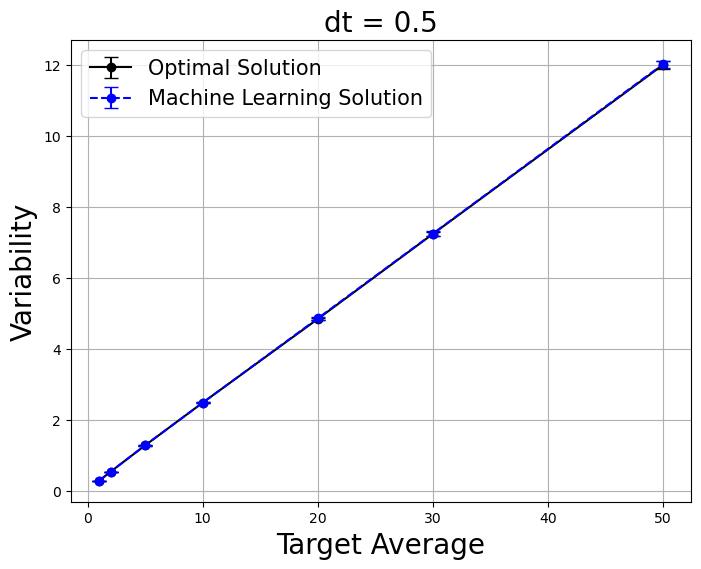

In [6]:
import numpy as np
import matplotlib.pyplot as plt

target_avgs = np.array([1, 2, 5, 10, 20, 30, 50])
reward_means_tgt = []
reward_stds_tgt = []

reward_means_tgt_opt = []
reward_stds_tgt_opt = []

for target in target_avgs:
    filename = "reward_array" + str(target) + ".txt"
    reward_array = np.loadtxt(filename)

    filename = "reward_opt_array" + str(target) + ".txt"
    reward_opt_array = np.loadtxt(filename)

    filename = "action_arrs" + str(target) + ".txt"
    action_arrs = np.loadtxt(filename)

    # Compute the average of the last X elements for each array, and the overall mean and standard deviation of these averages
    # Since we want variability, which is the negative reward, we'll insert a negative sign
    reward_array_averages = np.mean(-reward_array[:, -50000:], axis=1)
    overall_mean_reward = np.mean(reward_array_averages)
    overall_std_reward = np.std(reward_array_averages)

    #print (reward_array_averages)
    #print (overall_mean_reward, ' with var ', overall_std_reward)

    reward_array_averages_opt = np.mean(-reward_opt_array[:, -50000:], axis=1)
    overall_mean_reward_opt = np.mean(reward_array_averages_opt)
    overall_std_reward_opt = np.std(reward_array_averages_opt)

    reward_means_tgt.append(overall_mean_reward)
    reward_stds_tgt.append(overall_std_reward)
    
    reward_means_tgt_opt.append(overall_mean_reward_opt)
    reward_stds_tgt_opt.append(overall_std_reward_opt)

    ##now we obtain the average reward trace across the 10 seeds
    #rewards_overtime_average = np.mean(reward_array, axis=0)
    #rewards_overtime_opt_average = np.mean(reward_opt_array, axis=0)

    ##compute the value
    #rewards_overtime_average_val = np.mean(rewards_overtime_average[50000:,])
    #rewards_overtime_opt_average_val = np.mean(rewards_overtime_opt_average[50000:,])

    ##optional printing to check results
    #print ("The table's average overall is ", np.mean(rewards_overtime_average))
    #print ("The optimal controllers average overall is ", np.mean(rewards_overtime_opt_average))
    #print ("The table's average is ", rewards_overtime_average_val)
    #print ("The optimal controllers average is ", rewards_overtime_opt_average_val, ' \n')

np.savetxt("reward_means_an_avg.txt", reward_means_tgt)
np.savetxt("reward_std_an_avg.txt", reward_stds_tgt)

# Plotting the means with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(target_avgs, reward_means_tgt_opt, yerr=reward_stds_tgt_opt, fmt='o-',color='k', capsize=5, label='Optimal Controller')
plt.errorbar(target_avgs, reward_means_tgt, yerr=reward_stds_tgt, fmt='o--',color='b', capsize=5, label='Machine Learning Solution')

# Adding labels and title
plt.xlabel('Target Average', fontsize = 20)
plt.ylabel('Variability', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.title("dt = 0.5", fontsize = 20)

# Show plot
plt.grid(True)
plt.savefig("d05_comparison_analytic_model.png")
plt.show()



## Neural Nets Solution

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from collections import deque
import time
import random

from gymnasium import spaces
import molcontrol

## Parameters
##It takes extremely long to train a neural net compared to the lookup table. We split the training into half the steps for training, and half for testing
##And reduce the training time to 20000
steps = 10000 
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = np.array([0])
upper_mol = target*3

def neural_net_soln(steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED):
    ##For neural nets
    batch_size = 200
    model = molcontrol.NeuralNetwork([1, 64, 64, 1])
    learning_rate = 1e-3
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    replay_memory = molcontrol.ReplayMemory(capacity=2000)
    
    molcontrol.train_molecule_controller(model, optimizer, loss_fn, replay_memory, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
    rewards_overtime, q_error_overtime = molcontrol.test_molecule_controller(model, optimizer, loss_fn, replay_memory, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED, batch_size)
    return rewards_overtime, q_error_overtime

##Running the environment and learning
RUN_SEEDS = np.arange(0, 10)
target_avgs = np.array([1, 2, 5, 10, 20, 30, 50])

for target in target_avgs:
    net_rewards = []
    for SEED in RUN_SEEDS:
        rewards_overtime, q_error_overtime = neural_net_soln(steps, target, molecule_lifetime, dt, history_length, observable_indices, SEED)
        net_rewards.append(rewards_overtime)
        print ("Done seed ", SEED)

    reward_array = np.stack(net_rewards)
    np.savetxt("reward_array_nets"+str(target)+".txt", reward_array)

    print ("Done for all the seeds for average ", target)
print ("Done!")

Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for average  1
Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for average  2
Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for average  5
Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for average  10
Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for average  20
Done seed  0
Done seed  1
Done seed  2
Done seed  3
Done seed  4
Done seed  5
Done seed  6
Done seed  7
Done seed  8
Done seed  9
Done for all the seeds for a

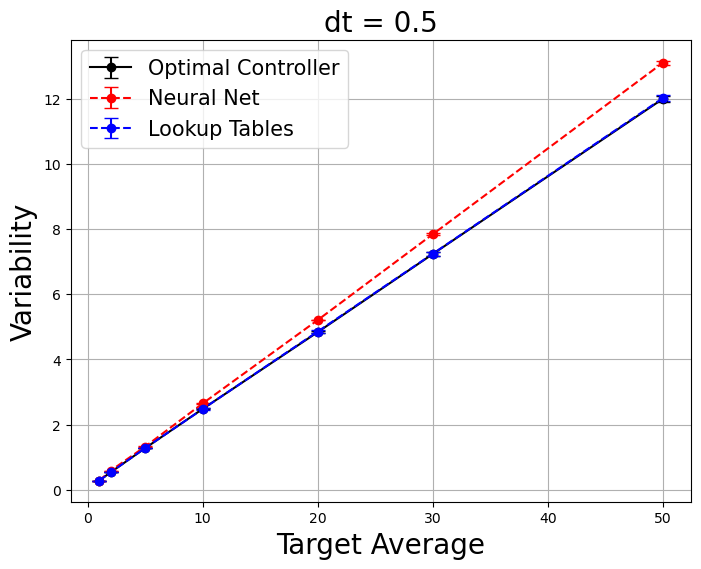

In [5]:
import numpy as np
import matplotlib.pyplot as plt

target_avgs = np.array([1, 2, 5, 10, 20, 30, 50])
reward_means_tgt = []
reward_stds_tgt = []

reward_means_tgt_opt = []
reward_stds_tgt_opt = []

reward_means_net = []
reward_stds_net = []

for target in target_avgs:
    filename = "reward_array" + str(target) + ".txt"
    reward_array = np.loadtxt(filename)

    filename = "reward_opt_array" + str(target) + ".txt"
    reward_opt_array = np.loadtxt(filename)

    filename = "action_arrs" + str(target) + ".txt"
    action_arrs = np.loadtxt(filename)

    filename = "reward_array_nets"+str(target)+".txt"
    reward_array_net = np.loadtxt(filename)

    # Compute the average of the last X elements for each array, and the overall mean and standard deviation of these averages
    # Since we want variability, which is the negative reward, we'll insert a negative sign
    reward_array_averages = np.mean(-reward_array[:, -50000:], axis=1)
    overall_mean_reward = np.mean(reward_array_averages)
    overall_std_reward = np.std(reward_array_averages)

    #print (reward_array_averages)
    #print (overall_mean_reward, ' with var ', overall_std_reward)

    reward_array_averages_opt = np.mean(-reward_opt_array[:, -50000:], axis=1)
    overall_mean_reward_opt = np.mean(reward_array_averages_opt)
    overall_std_reward_opt = np.std(reward_array_averages_opt)

    reward_means_tgt.append(overall_mean_reward)
    reward_stds_tgt.append(overall_std_reward)
    
    reward_means_tgt_opt.append(overall_mean_reward_opt)
    reward_stds_tgt_opt.append(overall_std_reward_opt)

    reward_array_averages_net = np.mean(-reward_array_net, axis=1) #neural net has less samples
    overall_mean_reward_net = np.mean(reward_array_averages_net)
    overall_std_reward_net = np.std(reward_array_averages_net)

    reward_means_net.append(overall_mean_reward_net)
    reward_stds_net.append(overall_std_reward_net)

    ##now we obtain the average reward trace across the 10 seeds
    #rewards_overtime_average = np.mean(reward_array, axis=0)
    #rewards_overtime_opt_average = np.mean(reward_opt_array, axis=0)

    ##compute the value
    #rewards_overtime_average_val = np.mean(rewards_overtime_average[50000:,])
    #rewards_overtime_opt_average_val = np.mean(rewards_overtime_opt_average[50000:,])

    ##optional printing to check results
    #print ("The table's average overall is ", np.mean(rewards_overtime_average))
    #print ("The optimal controllers average overall is ", np.mean(rewards_overtime_opt_average))
    #print ("The table's average is ", rewards_overtime_average_val)
    #print ("The optimal controllers average is ", rewards_overtime_opt_average_val, ' \n')

# Plotting the means with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(target_avgs, reward_means_tgt_opt, yerr=reward_stds_tgt_opt, fmt='o-',color='k', capsize=5, label='Optimal Controller')
plt.errorbar(target_avgs, reward_means_net, yerr=reward_stds_net, fmt='o--',color='r', capsize=5, label='Neural Net')
plt.errorbar(target_avgs, reward_means_tgt, yerr=reward_stds_tgt, fmt='o--',color='b', capsize=5, label='Lookup Tables')

# Adding labels and title
plt.xlabel('Target Average', fontsize = 20)
plt.ylabel('Variability', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.title("dt = 0.5", fontsize = 20)

# Show plot
plt.grid(True)
plt.savefig("d05_comparison_analytic_model_net.png")
plt.show()

